In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import utils
from utils import plot_univariate
from utils import log_reg_univariate
import matplotlib.pyplot as plt

In [12]:
# Load data set
df = pd.read_csv('data/final_data_set.csv', sep=';', encoding='utf-8')

# Basic characteristics

In [3]:
# Check the head and shape
print(df.shape)
df.head()

(356124, 15)


,Final,N,Country,Club,Points before,Finals before,First comp in class,Average points,Average finals,Number of participations,Days in class,Days since first comp,Previous number of participations,Days in previous class,Average rank in current class
0,1,24,CZ,DSP Kometa Brno,314,3,1,0.0,0.0,0.0,0,0,0.0,0.0,0.0
1,1,40,CZ,DSP Kometa Brno,356,4,0,21.0,0.5,1.0,6,6,0.0,0.0,0.5
2,0,8,CZ,DSP Kometa Brno,0,0,1,0.0,0.0,0.0,0,169,12.0,155.0,0.0
3,0,7,CZ,DSP Kometa Brno,2,0,0,1.0,0.0,1.0,12,181,12.0,155.0,3.0
4,0,14,CZ,DSP Kometa Brno,3,0,0,1.0,0.0,2.0,77,246,12.0,155.0,4.0


In [4]:
# Check missing values
df.isna().sum(axis=0) / df.shape[0]

Final                                0.0
N                                    0.0
Country                              0.0
Club                                 0.0
Points before                        0.0
Finals before                        0.0
First comp in class                  0.0
Average points                       0.0
Average finals                       0.0
Number of participations             0.0
Days in class                        0.0
Days since first comp                0.0
Previous number of participations    0.0
Days in previous class               0.0
Average rank in current class        0.0
dtype: float64

In [5]:
# Check summary
df.describe()

,Final,N,Points before,Finals before,First comp in class,Average points,Average finals,Number of participations,Days in class,Days since first comp,Previous number of participations,Days in previous class,Average rank in current class
count,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000,356124.000000
mean,0.239130,14.044996,77.888418,1.210014,0.077681,6.604680,0.119514,8.824600,221.955560,392.095105,6.075763,120.533404,6.301895
std,0.426553,8.406796,88.156112,1.877318,0.267669,5.757859,0.195253,8.984172,299.695282,472.545619,10.009953,269.158882,4.492774
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,11.000000,0.000000,0.000000,2.210526,0.000000,2.000000,35.000000,70.000000,0.000000,0.000000,3.500000
50%,0.000000,12.000000,51.000000,0.000000,0.000000,5.454545,0.000000,6.000000,134.000000,239.000000,0.000000,0.000000,5.777778
75%,0.000000,17.000000,123.000000,2.000000,0.000000,9.529871,0.173913,12.000000,301.000000,532.000000,11.000000,154.000000,8.142857
max,1.000000,65.000000,2111.000000,30.000000,1.000000,59.444444,0.947368,117.000000,6496.000000,6537.000000,116.000000,6029.000000,42.916667


# Univariate inspection

## Dependent variable

(array([0, 1]), [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

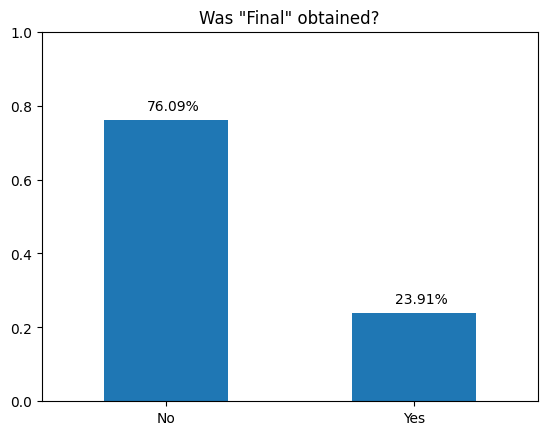

In [17]:
# Show class distribution
class_distrib = df['Final'].value_counts().rename({0:'No', 1:'Yes'}) / df.shape[0]
class_distrib.plot.bar(ylim=(0, 1))
for idx, val in enumerate(class_distrib): # Add labels above bars for readability
    plt.text(idx - 0.075, val + 0.025, f'{val:.2%}')
plt.title('Was "Final" obtained?')
plt.xlabel('')
plt.xticks(rotation=0)

## Univariate regressions (numerical)

In [13]:
num_vars = list(df.columns)
num_vars.remove('Final')
num_vars.remove('Club')
num_vars.remove('Country')
cat_vars = ['Club', 'Country']

In [34]:
# Obtain results of univariate regressions
aucs = {}
mses = {}
prsquareds = {}
pvals = {}
for var in num_vars:
    aucs_var = {}
    mses_var = {}
    prsquareds_var = {}
    pvals_var = {}
    for log_type in ['Base', 'Log', 'Squared', 'Log squared']:
        if log_type == 'Base':
            log, squared = False, False
        elif log_type == 'Log':
            log, squared = True, False
        elif log_type == 'Squared':
            log, squared =  False, True
        else:
            log, squared = True, True
        
        if (var == 'First comp in class') and (log_type in ['Squared', 'Log squared']):
            log_reg = [None, None, None, None]
        else:
            log_reg = log_reg_univariate(df[var], df['Final'], log, squared, robust=True)
        aucs_var[log_type], mses_var[log_type], prsquareds_var[log_type], pvals_var[log_type] = log_reg
    aucs[var], mses[var], prsquareds[var], pvals[var] = aucs_var, mses_var, prsquareds_var, pvals_var
    print(f'{var} done')

N done
Points before done
Finals before done
First comp in class done
Average points done
Average finals done
Number of participations done
Days in class done
Days since first comp done
Previous number of participations done
Days in previous class done
Average rank in current class done


In [38]:
# AUC
pd.DataFrame(aucs).T.sort_values('Base', ascending=False).round(3)#.to_excel('models/Univariate_AUCs.xlsx')

,Base,Log,Squared,Log squared
Average points,0.770,0.770,0.770,0.782
Average finals,0.741,0.741,0.741,0.741
Finals before,0.713,0.713,0.712,0.713
Average rank in current class,0.681,0.681,0.681,0.712
Points before,0.670,0.670,0.671,0.700
Previous number of participations,0.555,0.555,0.555,0.569
Days in previous class,0.551,0.551,0.551,0.557
Number of participations,0.540,0.540,0.545,0.555
N,0.536,0.536,0.536,0.536
Days since first comp,0.535,0.535,0.535,0.541


In [12]:
# Pseudo R-squared
pd.DataFrame(prsquareds).T.round(3).sort_values('Base', ascending=False)

,Base,Log,Squared,Log squared
Average points,0.153,0.137,0.161,0.165
Average finals,0.140,0.143,0.143,0.144
Finals before,0.095,0.107,0.104,0.107
Average rank in current class,0.065,0.037,0.066,0.092
Points before,0.039,0.037,0.061,0.066
Previous number of participations,0.011,0.007,0.011,0.013
Days in previous class,0.008,0.006,0.009,0.009
N,0.003,0.003,0.003,0.003
Days since first comp,0.002,0.001,0.003,0.003
First comp in class,0.001,0.001,NaN,NaN


In [13]:
# P values
pd.DataFrame(pvals).T

,Base,Log,Squared,Log squared
N,0.0,0.0,"[6.268659812761076e-38, 0.34346797295195]","[0.7931417992395258, 2.2138709209390974e-06]"
Points before,0.0,0.0,"[0.0, 1.4555554179979665e-130]","[0.0, 0.0]"
Finals before,0.0,0.0,"[0.0, 2.323388527387671e-235]","[0.0, 2.1192858277135475e-05]"
First comp in class,0.0,0.0,NaN,NaN
Average points,0.0,0.0,"[0.0, 0.0]","[0.0, 0.0]"
Average finals,0.0,0.0,"[0.0, 0.0]","[0.0, 1.4279456004982305e-130]"
Number of participations,0.0,0.0,"[1.4163805946189493e-159, 1.8998011432619062e-95]","[4.621483130640087e-241, 3.9142052532746267e-146]"
Days in class,0.784055,0.0,"[0.11586231840168656, 0.11559379079829449]","[5.113285137649301e-152, 5.1652539853083415e-101]"
Days since first comp,0.0,0.0,"[1.8472312098824812e-185, 8.273513281734411e-51]","[5.3709303219504465e-133, 4.2899897419539496e-..."
Previous number of participations,0.0,0.0,"[4.287634363250977e-69, 4.888587956632454e-13]","[9.733875424828767e-288, 0.0]"


## Categorical variables

In [210]:
# Club
club_mean = df.groupby('Club')['Final'].mean().sort_values(ascending=False)
club_count = df.groupby('Club')['Club'].count()
pd.merge(club_mean, club_count, left_index=True, right_index=True)

,Final,Club
Club,,
SUN DANCE ACADEMY BRATISLAVA,0.585185,135
TŠK Viva Nové Zámky,0.562500,96
Ostrava,0.562500,176
Professional Dance Sport,0.547619,84
Taneční škola Artimo,0.546667,150
...,...,...
Hluboké Mašůvky,0.059880,167
Malacky,0.058201,189
Taneční klub Styl,0.042254,142


In [217]:
# Country
country_mean = df.groupby('Country')['Final'].mean().sort_values(ascending=False)
country_count = df.groupby('Country')['Country'].count()
pd.merge(country_mean, country_count, left_index=True, right_index=True)

,Final,Country
Country,,
HUN,0.473684,152
POL,0.441350,2370
AUT,0.392157,102
Other,0.340426,47
SVK,0.311129,13901
CZ,0.233964,333440
GER,0.225000,40


## Plots

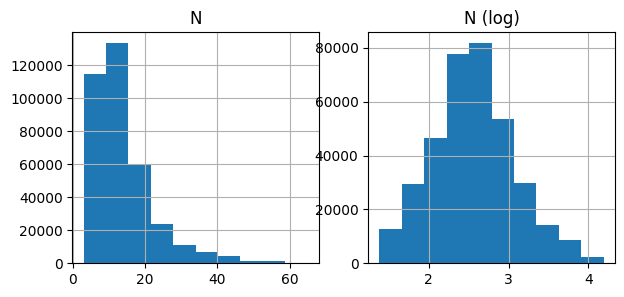

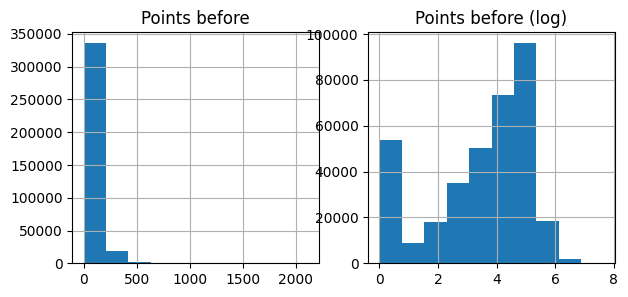

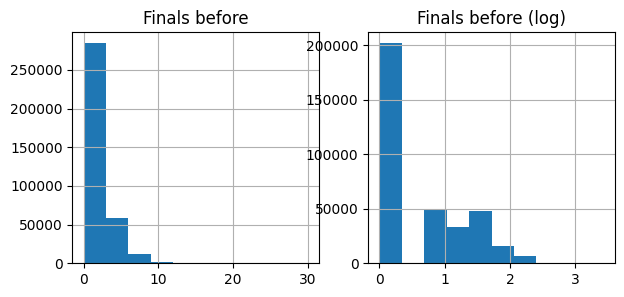

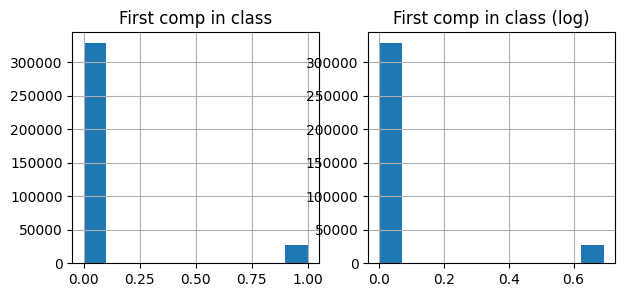

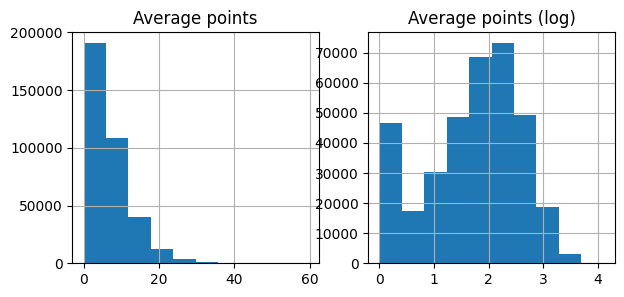

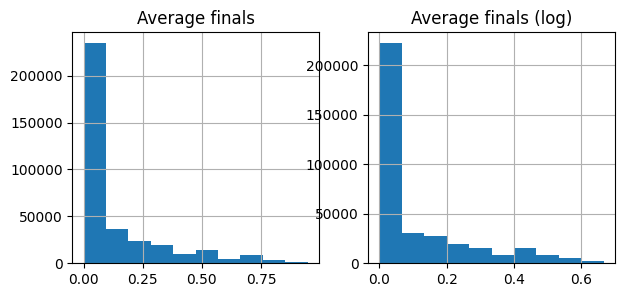

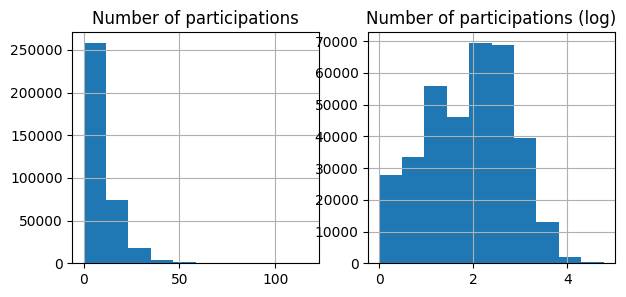

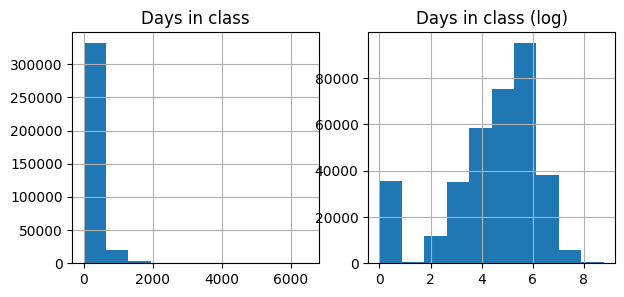

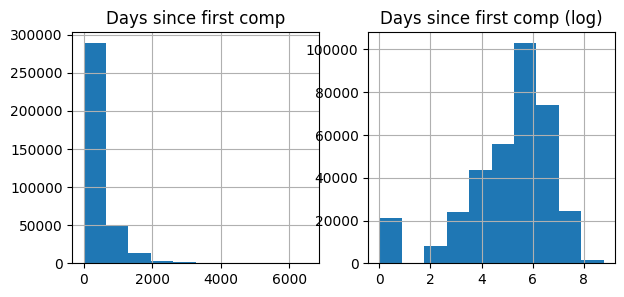

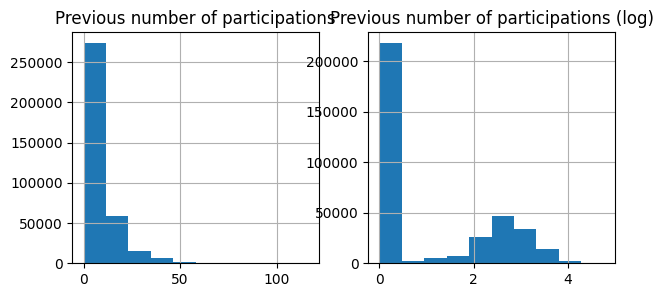

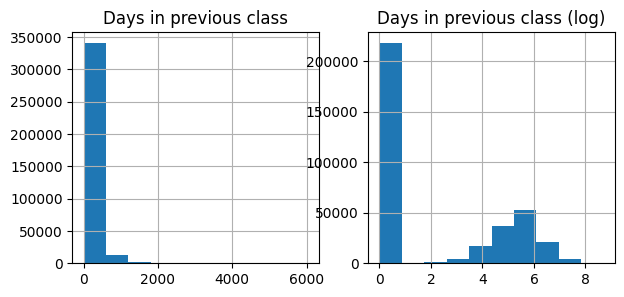

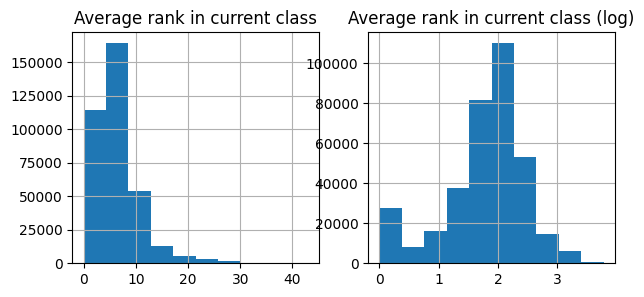

In [14]:
# Histograms
for var in num_vars:
    plot_univariate(df[var], out=f'Plots/Univariate/{var}.png')

## Correlations

In [15]:
# Correlation matrix
df[['Final'] + num_vars].corr()

,Final,N,Points before,Finals before,First comp in class,Average points,Average finals,Number of participations,Days in class,Days since first comp,Previous number of participations,Days in previous class,Average rank in current class
Final,1.000000,-0.059448,0.212963,0.340249,-0.036333,0.418283,0.416045,0.022493,0.000455,-0.050737,-0.104783,-0.082133,-0.238116
N,-0.059448,1.000000,0.164718,-0.053357,0.057506,0.228674,-0.018479,-0.083749,0.004740,0.009765,-0.035799,0.069664,0.408608
Points before,0.212963,0.164718,1.000000,0.565422,-0.170652,0.526671,0.275945,0.529678,0.347554,0.184329,-0.040475,-0.024692,0.131062
Finals before,0.340249,-0.053357,0.565422,1.000000,-0.129794,0.506517,0.712985,0.252111,0.128963,0.031842,-0.069308,-0.070941,-0.181205
First comp in class,-0.036333,0.057506,-0.170652,-0.129794,1.000000,-0.332895,-0.177639,-0.285058,-0.214933,-0.117973,-0.012722,0.003896,-0.407074
Average points,0.418283,0.228674,0.526671,0.506517,-0.332895,1.000000,0.702690,0.093685,0.084345,-0.000513,-0.128575,-0.060363,-0.052075
Average finals,0.416045,-0.018479,0.275945,0.712985,-0.177639,0.702690,1.000000,-0.020378,-0.023467,-0.070339,-0.117220,-0.085918,-0.296050
Number of participations,0.022493,-0.083749,0.529678,0.252111,-0.285058,0.093685,-0.020378,1.000000,0.654010,0.450961,0.144369,0.098631,0.286332
Days in class,0.000455,0.004740,0.347554,0.128963,-0.214933,0.084345,-0.023467,0.654010,1.000000,0.731909,0.157935,0.214147,0.299776
Days since first comp,-0.050737,0.009765,0.184329,0.031842,-0.117973,-0.000513,-0.070339,0.450961,0.731909,1.000000,0.596790,0.628862,0.238481


# Multivariate

Text(0.5, 1.0, 'AUC on the test set')

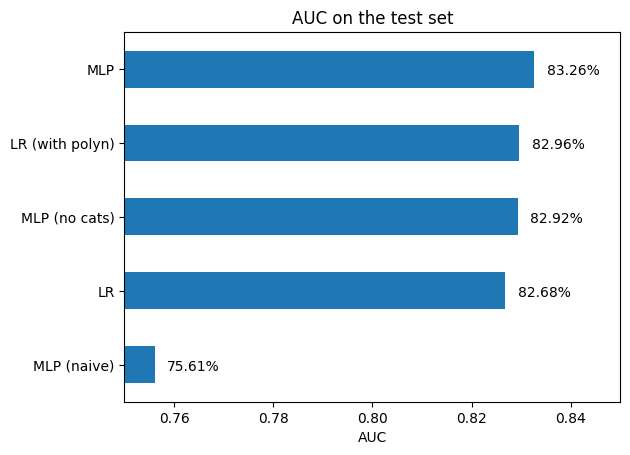

In [52]:
# Plot sklearn results
final_res = pd.Series({'MLP': 0.8326008344910798, 'MLP (no cats)': 0.8292492369696329, 'MLP (naive)':0.7560819704655737,
  'LR':0.8267652586088822, 'LR (with polyn)':0.8295947077048644}).sort_values(ascending=True)
final_res.plot.barh(xlim = (0.75, 0.85))
for idx, val in enumerate(final_res): # Add labels above bars for readability
    plt.text(val + 0.0025, idx - 0.075, f'{val:.2%}')
plt.xlabel('AUC')
plt.title('AUC on the test set')

## Logistic regression

In [53]:
# Estimate a logistic regression (all data)
vars = list(df.columns)
vars.remove('Final')
df_transf = pd.get_dummies(df[vars], columns=cat_vars, drop_first=True, dtype=int)
log_reg = sm.Logit(df['Final'], sm.add_constant(df_transf)).fit(cov_type='hc3')
log_reg.summary()

         Current function value: 0.418254
         Iterations: 35


c:\Users\matya\.conda\envs\nn\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Final   No. Observations:               356124
Model:                          Logit   Df Residuals:                   355750
Method:                           MLE   Df Model:                          373
Date:                Tue, 09 Jan 2024   Pseudo R-squ.:                  0.2396
Time:                        17:16:06   Log-Likelihood:            -1.4895e+05
converged:                      False   LL-Null:                   -1.9589e+05
Covariance Type:                  hc3   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.4627      0.271     -1.705      0.088      -0.995       0.069
N                                                -0.0338      0.001    -40.382      0.000      -0.035      -0.032
Points before                                   7.02e-06   8.67e-05      0.081      0.935      -0.000       0.000
Finals before                                     0.1340      0.004     32.729      0.000       0.126       0.142
First comp in class                               0.4806      0.024     19.665      0.000       0.433       0.528
Average points                                    0.1726      0.002    107.596      0.000       0.169       0.176
Average finals                                   -0.2273      0.045     -5.051      0.000      -0.316      -0.139
Number of participations                          0.0223      0.001     27.655      0.000       0.021       0.024
Days in class                                     0.0002   3.77e-05      5.663      0.000       0.000       0.000
Days since first comp                          -7.45e-05   2.84e-05     -2.622      0.009      -0.000   -1.88e-05
Previous number of participations                -0.0127      0.001    -13.938      0.000      -0.014      -0.011
Days in previous class                         -6.73e-05   4.51e-05     -1.491      0.136      -0.000    2.12e-05
Average rank in current class                    -0.1609      0.002    -68.178      0.000      -0.166      -0.156
Club_A.Klub Hranice                              -0.3735      0.260     -1.434      0.152      -0.884       0.137
Club_ATK Standard Cheb                           -0.1859      0.200     -0.929      0.353      -0.578       0.206
Club_Academia Latina Příbram                     -0.1116      0.219     -0.510      0.610      -0.540       0.317
Club_Akademie tanečního umění a sportu Duende     0.3573      0.302      1.182      0.237      -0.235       0.950
Club_Akadémia tanca Nitra                         0.2596      0.271      0.960      0.337      -0.271       0.790
Club_Akcent Ostrava                               0.1197      0.242      0.494      0.621      -0.355       0.594
Club_Altadance Sport                              0.1853      0.216      0.859      0.391      -0.238       0.608
Club_Armádní TK Havlíčkuv Brod                    0.2099      0.283      0.743      0.458      -0.344       0.764
Club_Armádní TK Havlíčkův Brod                   -0.4333      0.327     -1.324      0.186      -1.075       0.208
Club_Armádní taneční klub Havlíčkův Brod         -0.2523      0.290     -0.870      0.384      -0.821       0.316
Club_BAV klub Příbor                              0.1021      0.248      0.412      0.680      -0.384       0.588
Club_Bella Danza Děčín                           -0.2378      0.256     -0.930      0.352      -0.739       0.264
Club_Bene Dance Art Team                         

In [54]:
# Get coefficients and pvalues
coefs = log_reg.params
pvals = log_reg.pvalues
coefs = coefs[pvals <= 0.05]
pvals = pvals[pvals <= 0.05]
coefs.name, pvals.name = 'Coefficient', 'p-value'
coefs_and_pvals = pd.merge(coefs, pvals, left_index=True, right_index=True)
#coefs_and_pvals.drop('const', axis=0, inplace=True)
coefs_and_pvals[['Club' not in i for i in coefs_and_pvals.index]]

,Coefficient,p-value
N,-0.033787,0.000000e+00
Finals before,0.133968,6.014343e-235
First comp in class,0.480552,4.267224e-86
Average points,0.172556,0.000000e+00
Average finals,-0.227307,4.402133e-07
Number of participations,0.022340,2.440108e-168
Days in class,0.000213,1.485155e-08
Days since first comp,-0.000074,8.740361e-03
Previous number of participations,-0.012678,3.740420e-44
Average rank in current class,-0.160912,0.000000e+00


In [60]:
# Check clubs
coefs_and_pvals[['Club' in i for i in coefs_and_pvals.index]].sort_values('p-value')

,Coefficient,p-value
Club_TK Luna,-16.778031,0.000000
Club_Taneční škola Standardklub Praha,-1.158537,0.000022
Club_TŠ START Tábor,-1.196320,0.000063
Club_TK Grande Malacky,-2.003829,0.000285
Club_Stylklub Varnsdorf,-1.175043,0.000291
Club_Taneční sdružení Maxim,-1.216525,0.000323
Club_STK Kovosvit,-1.633782,0.000336
Club_KARKONOSZE Jelenia Góra,-0.811560,0.000733
Club_Taneční klub Styl,-1.480226,0.001317
Club_TK Apel Holice,-0.686097,0.001505


In [61]:
# Check positive clubs
coefs_and_pvals[['Club' in i and coefs_and_pvals.loc[i, 'Coefficient'] > 0 for i in coefs_and_pvals.index]].sort_values('p-value')

,Coefficient,p-value
Club_Ostrava,0.803598,0.002955
Club_Madat Praha,0.510401,0.013584
Club_Taneční klub StarStep,0.619644,0.028248
Club_Dynasit-DSP Kometa Brno,0.534394,0.034515


In [62]:
# Get AUC
roc_auc_score(df['Final'], log_reg.predict(sm.add_constant(df_transf)))

0.8232643958042982

## Logistic regression (log)

In [55]:
# Logistic regression with logarithmized features
df_transf_log = df_transf.copy()
df_transf_log[[i for i in num_vars if i != 'First comp in class']] = np.log(df_transf_log[[i for i in num_vars if i != 'First comp in class']] + 1)
log_reg_log = sm.Logit(df['Final'], sm.add_constant(df_transf_log)).fit(cov_type='hc3')
log_reg_log.summary()

         Current function value: 0.413377
         Iterations: 35


c:\Users\matya\.conda\envs\nn\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Final   No. Observations:               356124
Model:                          Logit   Df Residuals:                   355750
Method:                           MLE   Df Model:                          373
Date:                Tue, 09 Jan 2024   Pseudo R-squ.:                  0.2485
Time:                        17:18:53   Log-Likelihood:            -1.4721e+05
converged:                      False   LL-Null:                   -1.9589e+05
Covariance Type:                  hc3   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.9403      0.290     -3.238      0.001      -1.509      -0.371
N                                                -0.3981      0.012    -33.975      0.000      -0.421      -0.375
Points before                                    -0.0183      0.005     -3.458      0.001      -0.029      -0.008
Finals before                                     0.4603      0.013     34.766      0.000       0.434       0.486
First comp in class                               1.5675      0.043     36.408      0.000       1.483       1.652
Average points                                    1.4700      0.013    110.422      0.000       1.444       1.496
Average finals                                   -0.4586      0.056     -8.226      0.000      -0.568      -0.349
Number of participations                          0.1552      0.012     13.147      0.000       0.132       0.178
Days in class                                     0.1843      0.008     24.540      0.000       0.170       0.199
Days since first comp                            -0.1141      0.006    -18.801      0.000      -0.126      -0.102
Previous number of participations                -0.0927      0.018     -5.099      0.000      -0.128      -0.057
Days in previous class                            0.0245      0.009      2.677      0.007       0.007       0.042
Average rank in current class                    -1.1377      0.015    -73.603      0.000      -1.168      -1.107
Club_A.Klub Hranice                              -0.1318      0.256     -0.514      0.607      -0.634       0.371
Club_ATK Standard Cheb                           -0.2061      0.216     -0.956      0.339      -0.629       0.216
Club_Academia Latina Příbram                     -0.0726      0.233     -0.312      0.755      -0.529       0.383
Club_Akademie tanečního umění a sportu Duende     0.3754      0.304      1.236      0.217      -0.220       0.971
Club_Akadémia tanca Nitra                         0.3050      0.287      1.064      0.287      -0.257       0.867
Club_Akcent Ostrava                               0.2351      0.246      0.956      0.339      -0.247       0.717
Club_Altadance Sport                              0.2325      0.233      0.999      0.318      -0.224       0.689
Club_Armádní TK Havlíčkuv Brod                    0.1169      0.285      0.410      0.682      -0.442       0.676
Club_Armádní TK Havlíčkův Brod                   -0.4623      0.315     -1.467      0.142      -1.080       0.155
Club_Armádní taneční klub Havlíčkův Brod         -0.1567      0.303     -0.518      0.605      -0.750       0.437
Club_BAV klub Příbor                              0.0261      0.259      0.101      0.920      -0.482       0.534
Club_Bella Danza Děčín                           -0.1939      0.275     -0.705      0.481      -0.733       0.345
Club_Bene Dance Art Team                         

In [69]:
# Get coefficients and pvalues
coefs_log = log_reg_log.params
pvals_log = log_reg_log.pvalues
coefs_log = coefs_log[pvals_log <= 0.05]
pvals_log = pvals_log[pvals_log <= 0.05]
coefs_log.name, pvals_log.name = 'Coefficient', 'p-value'
coefs_and_pvals_log = pd.merge(coefs_log, pvals_log, left_index=True, right_index=True)
coefs_and_pvals_log.drop('const', axis=0, inplace=True)
coefs_and_pvals_log[['Club' not in i for i in coefs_and_pvals_log.index]].sort_values('p-value').round(4)#.to_excel('models/LR_coefs_pvals.xlsx')

,Coefficient,p-value
Average points,1.4700,0.0000
Average rank in current class,-1.1377,0.0000
First comp in class,1.5675,0.0000
Finals before,0.4603,0.0000
N,-0.3981,0.0000
Days in class,0.1843,0.0000
Days since first comp,-0.1141,0.0000
Number of participations,0.1552,0.0000
Average finals,-0.4586,0.0000
Previous number of participations,-0.0927,0.0000


In [57]:
# Check clubs
coefs_and_pvals_log[['Club' in i for i in coefs_and_pvals_log.index]].sort_values('p-value')

,Coefficient,p-value
Club_TK Luna,-15.754453,0.000000
Club_Taneční sdružení Maxim,-1.311976,0.000123
Club_TK Grande Malacky,-2.060076,0.000310
Club_STK Kovosvit,-1.493576,0.000514
Club_Stylklub Varnsdorf,-1.069528,0.000989
Club_Taneční škola Standardklub Praha,-0.882094,0.001707
Club_TŠ START Tábor,-1.019636,0.001758
Club_Taneční klub Styl,-1.479821,0.001870
Club_KARKONOSZE Jelenia Góra,-0.763779,0.002870
Club_TŠ Duha Česká Lípa,-0.690656,0.003959


In [58]:
# Check positive clubs
coefs_and_pvals_log[['Club' in i and coefs_and_pvals_log.loc[i, 'Coefficient'] > 0 for i in coefs_and_pvals_log.index]].sort_values('p-value')

,Coefficient,p-value
Club_Ostrava,0.805100,0.004966
Club_Madat Praha,0.536926,0.014508
Club_Taneční klub StarStep,0.723173,0.016026
Club_Sokol Vítkovice- TK Akcent Ostrava,0.544550,0.018533
Club_SUN DANCE ACADEMY BRATISLAVA,0.581132,0.044645


In [59]:
# Get AUC
roc_auc_score(df['Final'], log_reg_log.predict(sm.add_constant(df_transf_log)))

0.8267753061813179

## Predicting competition

In [19]:
# Load data set with all columns
df = pd.read_csv('data/final_all_cols_data_set.csv', sep=';', encoding='utf-8')

In [20]:
# Find the competition of interest
test_mask = (df['Title'] == 'Zimní SPARTA CUP 2023 - Praha') & (df['Age group'] == 'Dospělí') & (df['Class'] == 'D') & (df['Type'] == 'LAT')
df_test = df.loc[test_mask, :].copy()
df_test.sort_values('Rank', inplace=True)
df_test

,Final,Taneční pár,N,Country,Club,Obtained final,Obtained points,Points after,Finals after,Points before,...,Average points,Average finals,Number of participations,Days in class,Days since first comp,Previous class,Previous number of participations,Days in previous class,Rank prev,Average rank in current class
196978,1,Najman Jakub & Říhová Monika,9,CZ,TŠ Easy Dance 2000 Nymburk,1,25,192,3,167,...,8.350000,0.100000,19.0,246,1499,E,17.0,932.0,2,5.050000
178710,1,Mattanelli Matyáš & Šupíková Dorota,9,CZ,STK Praha,1,19,216,5,197,...,8.565217,0.173913,22.0,358,652,E,16.0,260.0,1,6.217391
226332,0,Peťovský Roman & Vilímová Adéla,9,CZ,STK Praha,0,13,174,2,161,...,9.470588,0.117647,16.0,546,652,E,9.0,91.0,3,5.117647
152090,0,Kupka Vojtěch & Voitle Vanesa,9,CZ,LR Cosmetic Dance Team Ostrava,0,7,44,0,37,...,3.363636,0.000000,10.0,77,218,E,8.0,134.0,3,5.454545
16049,0,Blecha Ondřej & Česenková Karolína,9,CZ,Top Dance Prague Team,0,6,61,0,55,...,3.437500,0.000000,15.0,252,539,E,14.0,280.0,6,7.437500
107956,0,Jiráček Jan & Kutzendörferová Eliška,9,CZ,TK Sparta Praha,0,5,16,0,11,...,2.750000,0.000000,3.0,8,8,E,0.0,0.0,4,2.750000
203727,0,Novotný Lukáš & Bednaříková Veronika,9,CZ,TK Astra Praha,0,2,174,5,172,...,10.750000,0.312500,15.0,196,288,E,11.0,71.0,1,4.250000
359218,0,Špringl Adam & Vašková Eliška,9,CZ,Taneční klub FIS,0,1,37,0,36,...,3.000000,0.000000,11.0,56,246,E,18.0,182.0,5,5.500000
171647,0,Malý Rostislav & Oharková Milena,9,CZ,Chomutov,0,0,22,0,22,...,2.444444,0.000000,8.0,70,70,E,0.0,0.0,6,6.777778


In [21]:
# Estimate the model
num_vars = ['N', 'Points before', 'Finals before', 'Average points', 'Average finals', 'Number of participations', 'Days in class',
 'Days since first comp', 'Previous number of participations', 'Days in previous class', 'Average rank in current class']
cat_vars = ['Club', 'Country', 'First comp in class']
model = utils.make_pipeline(MLPClassifier(random_state=123, max_iter=500, hidden_layer_sizes=100, alpha=0.01, activation='tanh'), list(range(len(num_vars))), list(range(len(num_vars), len(num_vars) + len(cat_vars))))
model.fit(df.loc[np.invert(test_mask), num_vars + cat_vars], df.loc[np.invert(test_mask), 'Final'])

Pipeline(steps=[('log_transform',
                 ColumnTransformer(transformers=[('log_tranform',
                                                  FunctionTransformer(func=<function make_pipeline.<locals>.<lambda> at 0x0000020F0F8AAB60>),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10]),
                                                 ('pass', 'passthrough',
                                                  [11, 12, 13])])),
                ('scale_and_hot',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10]),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [11, 12, 13])])),
                ('model',
                 MLPClassifier(activation='tanh', alpha=0.01,
                               hidden_layer_sizes=100, max_iter=500,
                               random_state=123))])

In [22]:
# Make the predictions
df_test['Prediction'] = model.predict_proba(df_test[num_vars + cat_vars])[:, 1]

In [30]:
# Check sorting
df_test['Prediction'] = df_test['Prediction'].round(2)
df_test.loc[:, ['Rank', 'Taneční pár', 'Club', 'Obtained points', 'Obtained final', 'Prediction']]#.to_excel('data/sorted_comp.xlsx', index=False)

,Rank,Taneční pár,Club,Obtained points,Obtained final,Prediction
196978,1,Najman Jakub & Říhová Monika,TŠ Easy Dance 2000 Nymburk,25,1,0.30
178710,2,Mattanelli Matyáš & Šupíková Dorota,STK Praha,19,1,0.37
226332,3,Peťovský Roman & Vilímová Adéla,STK Praha,13,0,0.40
152090,4,Kupka Vojtěch & Voitle Vanesa,LR Cosmetic Dance Team Ostrava,7,0,0.10
16049,5,Blecha Ondřej & Česenková Karolína,Top Dance Prague Team,6,0,0.08
107956,6,Jiráček Jan & Kutzendörferová Eliška,TK Sparta Praha,5,0,0.05
203727,7,Novotný Lukáš & Bednaříková Veronika,TK Astra Praha,2,0,0.51
359218,8,Špringl Adam & Vašková Eliška,Taneční klub FIS,1,0,0.08
171647,9,Malý Rostislav & Oharková Milena,Chomutov,0,0,0.04
